In [1]:
import numpy as np
import pandas as pd
import cPickle as pkl
import linearcorex
from matplotlib import pyplot as plt

Install CUDA and cudamat (for python) to enable GPU speedups.


# Load Stock Data

In [2]:
def load_data():
    with open('../data/EOD_week.pkl', 'rb') as f:
        df = pd.DataFrame(pkl.load(f))
    return df

In [3]:
df = load_data()
print("Data.shape = {}".format(df.shape))

Data.shape = (887, 5038)


# Train linear corex for single window

In [18]:
corex_params = {
    'n_hidden':10,
    'max_iter':300,
    'tol':1e-5,
    'anneal':True,
    'missing_values':None,
    'discourage_overlap':True,
    'gaussianize':'standard',
    'gpu':False,
    'verbose':True,
    'seed':None
}

In [19]:
corex = linearcorex.Corex(**corex_params)

Linear CorEx with 10 latent factors


In [20]:
corex.fit(df[:200])

275 iterations to tol: 0.000010
70 iterations to tol: 0.000010
38 iterations to tol: 0.000010


In [21]:
corex.tc

663.93938827514648

# Running 10 times and averaging

In [22]:
all_values = []

In [23]:
for i in range(10):
    corex = linearcorex.Corex(**corex_params)
    corex.fit(df[:200])
    all_values += [corex.tc]

Linear CorEx with 10 latent factors
277 iterations to tol: 0.000010
43 iterations to tol: 0.000010
30 iterations to tol: 0.000010
50 iterations to tol: 0.000010
67 iterations to tol: 0.000010
Linear CorEx with 10 latent factors
68 iterations to tol: 0.000010
97 iterations to tol: 0.000010
56 iterations to tol: 0.000010
Linear CorEx with 10 latent factors
203 iterations to tol: 0.000010
33 iterations to tol: 0.000010
106 iterations to tol: 0.000010
96 iterations to tol: 0.000010
57 iterations to tol: 0.000010
Linear CorEx with 10 latent factors
132 iterations to tol: 0.000010
110 iterations to tol: 0.000010
69 iterations to tol: 0.000010
Linear CorEx with 10 latent factors
114 iterations to tol: 0.000010
92 iterations to tol: 0.000010
68 iterations to tol: 0.000010
Linear CorEx with 10 latent factors
84 iterations to tol: 0.000010
Linear CorEx with 10 latent factors
225 iterations to tol: 0.000010
221 iterations to tol: 0.000010
61 iterations to tol: 0.000010
108 iterations to tol: 0.00

In [24]:
print "{} runs".format(len(all_values))
print "mean = {}".format(np.mean(all_values))
print "max  = {}".format(np.max(all_values))
print "min  = {}".format(np.min(all_values))

10 runs
mean = 653.812761497
max  = 664.056051254
min  = 648.960245132


In [ ]:
10 runs
mean = 649.415188599
max  = 663.744283676
min  = 643.058347702

## Covariance Matrix 

In [ ]:
cov = corex.get_covariance()
plt.imshow(cov[:20, :20])
plt.show()

## Mutual Informations

In [ ]:
mis = corex.mis
plt.imshow(mis[:, :20])
plt.show()

In [10]:
def get_parent(corex, i):
    """Get parent of `xi` in a learned CorEx model"""
    return np.argmax(corex.mis[:, i])

### print parents

In [11]:
print([get_parent(corex, i) for i in range(20)])

[1, 1, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


## Try to get right order of hidden factors

In [12]:
def match_order(A, B):
    """ Given two instances of CorEx: A and B, this function tries
    to reorder hidden factors for B to match the order of hidden 
    factors of A.
    Each hidden factor of B is matched to some hidden factor of B
    with which they have the most children overlap.
    
    NOTE: is this precise enough ?
    """

    used = [False] * A.m
    btoa = [None] * A.m # mapping from B to A
    
    cnt_match = np.zeros((A.m, B.m))
    for x in range(A.nv):
        ai = get_parent(A, x)
        bj = get_parent(B, x)
        cnt_match[ai, bj] += 1
    
    for j in range(B.m):
        best = None
        best_overlap = None
        for i in range(A.m):
            if used[i]:
                continue
            cur_overlap = cnt_match[i, j]
            if (best_overlap is None) or (cur_overlap > best_overlap):
                best = i
                best_overlap = cur_overlap
        
        assert best is not None
        used[best] = True
        btoa[j] = best
    
    return btoa

# Train 2 different corexes on different time windows

In [63]:
start_A = 0
end_A = 200
start_B = 20
end_B = 220

XA = df[start_A:end_A]
XB = df[start_B:end_B]

corex_params = {
    'n_hidden':10,
    'max_iter':150,
    'tol':1e-5,
    'anneal':True,
    'missing_values':None,
    'discourage_overlap':True,
    'gaussianize':'standard',
    'gpu':False,
    'verbose':True,
    'seed':None
}

In [64]:
A = linearcorex.Corex(**corex_params)
B = linearcorex.Corex(**corex_params)

Linear CorEx with 10 latent factors
Linear CorEx with 10 latent factors


In [65]:
A.fit(XA)

In [66]:
B.fit(XB)

123 iterations to tol: 0.000010
86 iterations to tol: 0.000010
138 iterations to tol: 0.000010


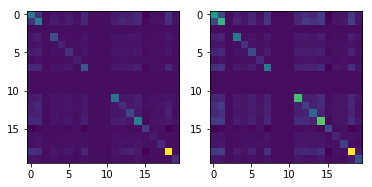

In [51]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(A.get_covariance()[:20, :20])
ax[1].imshow(B.get_covariance()[:20, :20])
plt.show()

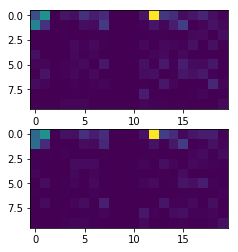

In [52]:
fig, ax = plt.subplots(nrows=2)
ax[0].imshow(A.mis[:, :20])
ax[1].imshow(B.mis[:, :20])
plt.show()

### try match hiddens

In [53]:
btoa = match_order(A,B)

NameError: name 'match_order' is not defined

In [ ]:
fig, ax = plt.subplots(nrows=2)
ax[0].imshow(A.mis[:, :20])
ax[1].imshow(B.mis[btoa, :20])
plt.show()

### TCs

In [54]:
A.tc

648.96916580200195

In [55]:
B.tc

676.7777214050293

TODO:
    a. create copy of linear corex in linear corex library
    b. add L1, L2 regularizations on differences of Ws and add to objective function
        I guess this is the most basic type of regularization we can add
        Calculate second order gradients to allow to use Quasi Newton optmization
    c. Introduce some metrics to understand if the regularization changes something
        Good starting point for this is the paper Aram mentioned: Time-varying network inference via graphical lasso
        
NOTE:
    a. in corex objective we they calculate H(Zj) the write 1/2 * log(E[zj^2]) but it should be log(E[zj]^2 - E[zj^2])